### Vechicle Detection

#### In this project, I will write a software pipeline to detect vehicles in a video.  


The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

Important Note:   
*the value of png read by mpimg.imread() ranges from 0 to 1*  
*the value of jpg read by mpimg.imread() ranges from 0 to 255* 

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from skimage.feature import hog
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from collections import deque

%matplotlib qt5
%matplotlib inline

Your function returned a count of 8792 cars and 8968 non-cars
of size: (64, 64, 3) and data type: float32


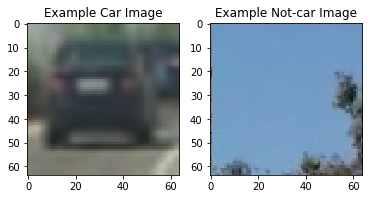

In [2]:
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

# Read in cars and notcars
cars = []
notcars = []
for folder in glob.glob('train_image/vehicles/*'):
    for img in glob.glob(folder+'/*'):
        cars.append(img)
for folder in glob.glob('train_image/non-vehicles/*'):
    for img in glob.glob(folder+'/*'):
        notcars.append(img)

data_info = data_look(cars, notcars)

print('Your function returned a count of {} cars and {} non-cars'
      .format(data_info["n_cars"], data_info["n_notcars"]))

print('of size: {} and data type: {}'.format(data_info["image_shape"], data_info["data_type"]))

# Read in car / not-car images
car_image = mpimg.imread(cars[0])
notcar_image = mpimg.imread(notcars[0])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.savefig('output_images/car_not-car.jpg',bbox_inches='tight')

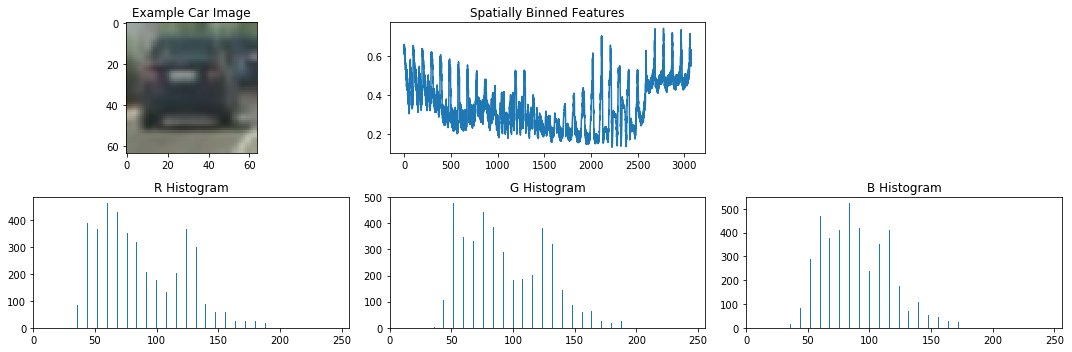

In [3]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

car_image = mpimg.imread(cars[0])

spa_bin = bin_spatial(car_image)

hist = color_hist(car_image, nbins=32, bins_range=(0, 1))
bin_edges = 32
bincen = []
for i in range(4, 256, 8):
    bincen.append(float(i))
#print(len(bincen), bincen)
#print(len(hist[0:32]), hist[0:32])
#print(len(hist[32:64]), hist[32:64])

fig = plt.figure(figsize=(15,5))
plt.subplot(231)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(232)
plt.plot(spa_bin)
plt.title('Spatially Binned Features')
plt.subplot(234)
plt.bar(bincen, hist[0:32])
plt.xlim(0, 256)
plt.title('R Histogram')
plt.subplot(235)
plt.bar(bincen, hist[32:64])
plt.xlim(0, 256)
plt.title('G Histogram')
plt.subplot(236)
plt.bar(bincen, hist[64:96])
plt.xlim(0, 256)
plt.title('B Histogram')
fig.tight_layout()
plt.savefig('output_images/spatial_hist.jpg',bbox_inches='tight')

/Users/lai/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


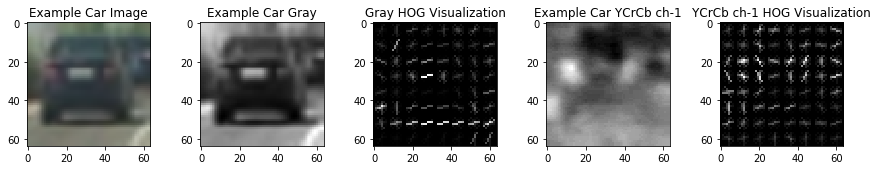

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
hog_feat = True # HOG features on or off

car_image = mpimg.imread(cars[0])
car_gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
gray_features, gray_hog_image = get_hog_features(car_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
car_YCrCb = cv2.cvtColor(car_image, cv2.COLOR_RGB2YCrCb)
YCrCb_features, YCrCb_hog_image = get_hog_features(car_YCrCb[:,:,1], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure(figsize=(15,5))
plt.subplot(251)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(252)
plt.imshow(car_gray, cmap='gray')
plt.title('Example Car Gray')
plt.subplot(253)
plt.imshow(gray_hog_image, cmap='gray')
plt.title('Gray HOG Visualization')
plt.subplot(254)
plt.imshow(car_YCrCb[:,:,1], cmap='gray')
plt.title('Example Car YCrCb ch-1')
plt.subplot(255)
plt.imshow(YCrCb_hog_image, cmap='gray')
plt.title('YCrCb ch-1 HOG Visualization')
plt.savefig('output_images/car_hog.jpg',bbox_inches='tight')

In [5]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, hist_range=(0, 256), orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


In [6]:
# Run the different combinatioins of parameters to get the best training parameters.
'''
ls_color_space = ['HSV', 'YUV', 'YCrCb']
orient = 9  # HOG orientations
ls_pix_per_cell = [8,16] # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
hist_range = (0, 1) # For *.png
ls_spatial_feat = [False, True] # Spatial features on or off
ls_hist_feat = [False, True] # Histogram features on or off
hog_feat = True # HOG features on or off

for color_space in ls_color_space:
    for pix_per_cell in ls_pix_per_cell:
        for spatial_feat,hist_feat in zip(ls_spatial_feat, ls_hist_feat):
            print('color space = {}, spatial bin and histogram = {}'.format(color_space,spatial_feat))
            car_features = extract_features(cars, color_space=color_space, 
                                    spatial_size=spatial_size, hist_bins=hist_bins, 
                                    orient=orient, hist_range=hist_range, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                    hist_feat=hist_feat, hog_feat=hog_feat)
            notcar_features = extract_features(notcars, color_space=color_space, 
                                    spatial_size=spatial_size, hist_bins=hist_bins, 
                                    orient=orient, hist_range=hist_range, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                    hist_feat=hist_feat, hog_feat=hog_feat)
            
            X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
            # Fit a per-column scaler
            X_scaler = StandardScaler().fit(X)
            # Apply the scaler to X
            scaled_X = X_scaler.transform(X)
            
            # Define the labels vector
            y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
            
            # Split up data into randomized training and test sets
            rand_state = np.random.randint(0, 100)
            X_train, X_test, y_train, y_test = train_test_split(
                scaled_X, y, test_size=0.2, random_state=rand_state)
            
            print('Using: {} orientations, {} pixels per cell and {} cells per block'
                  .format(orient, pix_per_cell, cell_per_block))
            print('Feature vector length: {}'.format(len(X_train[0])))
            # Use a linear SVC 
            svc = LinearSVC()
            # Check the training time for the SVC
            t=time.time()
            svc.fit(X_train, y_train)
            t2 = time.time()
            print('{} Seconds to train SVC...'.format(round(t2-t, 2)))
            
            # Check the score of the SVC
            print('Test Accuracy of SVC = {}\n'.format(round(svc.score(X_test, y_test), 4)))
'''            

'\nls_color_space = [\'HSV\', \'YUV\', \'YCrCb\']\norient = 9  # HOG orientations\nls_pix_per_cell = [8,16] # HOG pixels per cell\ncell_per_block = 2 # HOG cells per block\nhog_channel = \'ALL\' # Can be 0, 1, 2, or "ALL"\nspatial_size = (32, 32) # Spatial binning dimensions\nhist_bins = 32    # Number of histogram bins\nhist_range = (0, 1) # For *.png\nls_spatial_feat = [False, True] # Spatial features on or off\nls_hist_feat = [False, True] # Histogram features on or off\nhog_feat = True # HOG features on or off\n\nfor color_space in ls_color_space:\n    for pix_per_cell in ls_pix_per_cell:\n        for spatial_feat,hist_feat in zip(ls_spatial_feat, ls_hist_feat):\n            print(\'color space = {}, spatial bin and histogram = {}\'.format(color_space,spatial_feat))\n            car_features = extract_features(cars, color_space=color_space, \n                                    spatial_size=spatial_size, hist_bins=hist_bins, \n                                    orient=orient, hist

In [7]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
hist_range = (0, 1) # For *.png
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
    
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, hist_range=hist_range, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, hist_range=hist_range, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using: {} orientations, {} pixels per cell and {} cells per block'
      .format(orient, pix_per_cell, cell_per_block))
print('Feature vector length: {}'.format(len(X_train[0])))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print('{} Seconds to train SVC...'.format(round(t2-t, 2)))

# Check the score of the SVC
print('Test Accuracy of SVC = {}'.format(round(svc.score(X_test, y_test), 4)))


/Users/lai/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations, 16 pixels per cell and 2 cells per block
Feature vector length: 4140
10.33 Seconds to train SVC...
Test Accuracy of SVC = 0.9868


In [8]:
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('output     {}'.format(y_test[0:n_predict]))
print('Prediction {}'.format(svc.predict(X_test[0:n_predict])))
t2=time.time()
print('{} Seconds to predict {} labels with SVC'.format(round(t2-t, 5), n_predict))


output     [ 0.  1.  1.  0.  1.  0.  1.  0.  0.  1.]
Prediction [ 0.  1.  1.  0.  1.  0.  1.  0.  0.  1.]
0.00194 Seconds to predict 10 labels with SVC


In [9]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, hist_range=hist_range, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

/Users/lai/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


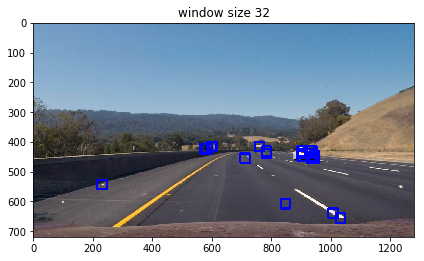

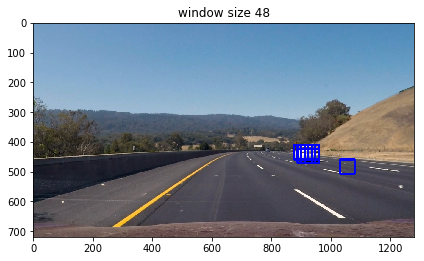

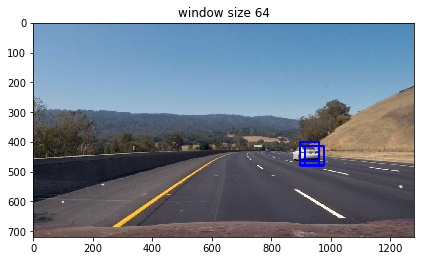

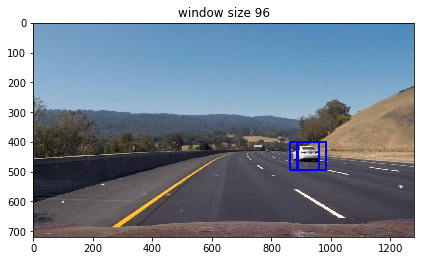

In [10]:
# Using different window size to detect vehicles.
y_start_stop = [400, 700] # Min and max in y to search in slide_window()

ls_window_size = [(32, 32), (48, 48), (64, 64), (96, 96)]
window_overlap = (0.75, 0.75)

image = mpimg.imread('test_images/test3.jpg')
cp_image = np.copy(image)
image = image.astype(np.float32)/255 # mpimg.imread *.jpg, 0 to 255

for window_size in ls_window_size:
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=window_size, xy_overlap=window_overlap)
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(cp_image, hot_windows, color=(0, 0, 255), thick=6)                    
    
    fig = plt.figure()
    plt.subplot()
    plt.imshow(window_img)
    plt.title('window size '+str(window_size[0]))
    fig.tight_layout()
    plt.savefig('output_images/window_size_'+str(window_size[0])+'.jpg',bbox_inches='tight')

/Users/lai/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


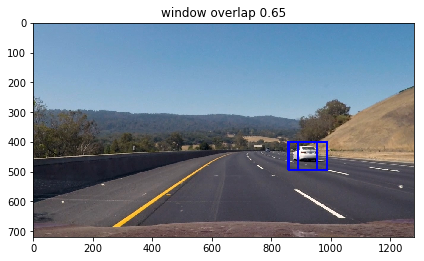

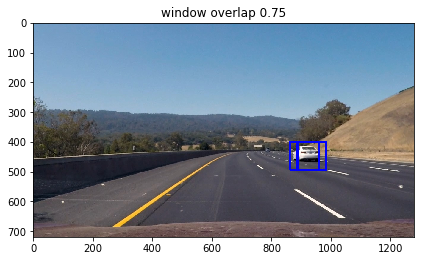

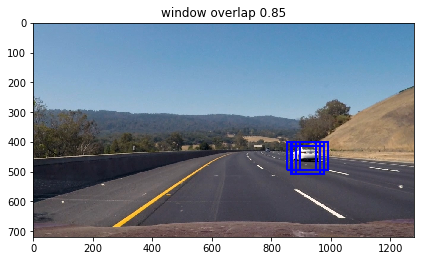

In [11]:
# Using different window step to detect vehicles.
y_start_stop = [400, 700] # Min and max in y to search in slide_window()

window_size = (96, 96)
ls_window_overlap = [(0.65, 0.65), (0.75, 0.75), (0.85, 0.85)]

image = mpimg.imread('test_images/test3.jpg')
cp_image = np.copy(image)
image = image.astype(np.float32)/255 # mpimg.imread *.jpg, 0 to 255

for window_overlap in ls_window_overlap:
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=window_size, xy_overlap=window_overlap)
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(cp_image, hot_windows, color=(0, 0, 255), thick=6)                    
    
    fig = plt.figure()
    plt.subplot()
    plt.imshow(window_img)
    plt.title('window overlap '+str(window_overlap[0]))
    fig.tight_layout()
    plt.savefig('output_images/window_overlap_'+str(window_overlap[0])+'.jpg',bbox_inches='tight')

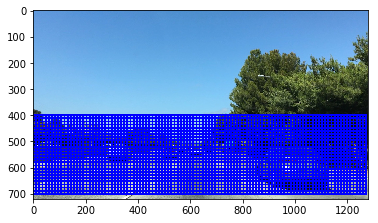

In [12]:
# Draw all sliding windows on image.
ls_window_size = [(48, 48), (96, 96)]
window_overlap = (0.75, 0.75)

image = mpimg.imread('cutouts/bbox-example-image.jpg')
cp_image = np.copy(image)
image = image.astype(np.float32)/255 # mpimg.imread *.jpg, 0 to 255

hot_windows = []
for window_size in ls_window_size:
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=window_size, xy_overlap=window_overlap)
    hot_windows.extend(windows)
window_img = draw_boxes(cp_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
plt.savefig('output_images/slide_window.jpg',bbox_inches='tight')
    

/Users/lai/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


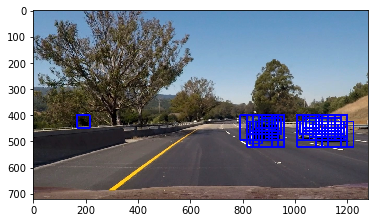

In [13]:
# Apply slide_window() and search_windows() on testing images.
ls_window_size = [(48, 48), (96, 96)]
window_overlap = (0.75, 0.75)

for img in glob.glob('test_images/test*'):
    image = mpimg.imread(img)
    cp_image = np.copy(image)
    image = image.astype(np.float32)/255 # mpimg.imread *.jpg, 0 to 255

    hot_windows = []
    for window_size in ls_window_size:
        windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=window_size, xy_overlap=window_overlap)

        hot_windows.extend(search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))                      

    window_img = draw_boxes(cp_image, hot_windows, color=(0, 0, 255), thick=6)                    

    plt.imshow(window_img)
    plt.savefig('output_images/'+img.split('/')[1],bbox_inches='tight')


In [14]:
# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
#box_list = pickle.load( open( "bbox_pickle.p", "rb" ))

# Read in image similar to one shown above 
#image = mpimg.imread('test_image.jpg')
#heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image
    return imcopy


/Users/lai/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


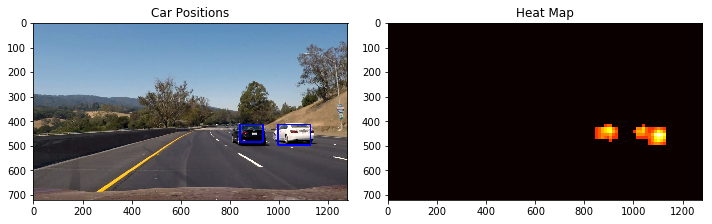

In [15]:
# Using heatmap to filter out false positives.
heat_threshold = 6

image = mpimg.imread('test_images/series1.jpg')

cp_image = np.copy(image)
image = image.astype(np.float32)/255 # mpimg.imread *.jpg, 0 to 255

hot_windows = []
for window_size in ls_window_size:
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=window_size, xy_overlap=window_overlap)
    
    hot_windows.extend(search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))                      

#window_img = draw_boxes(cp_image, hot_windows, color=(0, 0, 255), thick=6)                    
    
heat = np.zeros_like(image[:,:,0]).astype(np.float)
box_list = hot_windows
# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,heat_threshold)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
heat_window_img = draw_labeled_bboxes(cp_image, labels, (0,0,255))

fig = plt.figure(figsize = (10,10))
plt.subplot(121)
plt.imshow(heat_window_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.savefig('output_images/box_heat.jpg',bbox_inches='tight')


/Users/lai/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


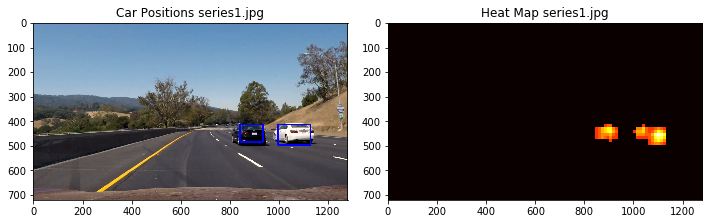

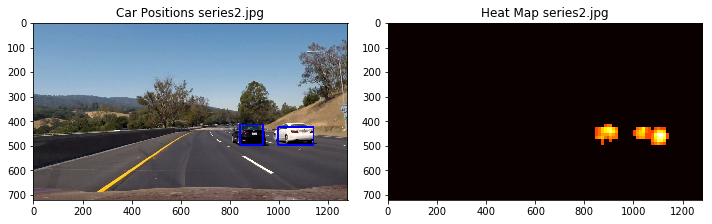

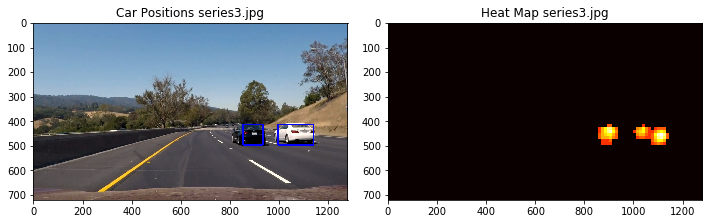

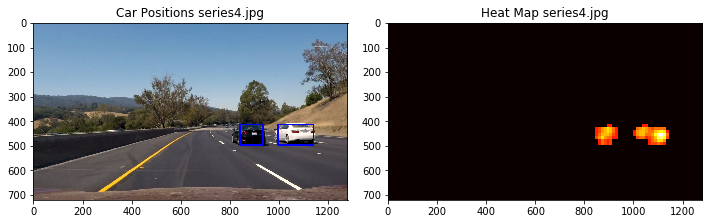

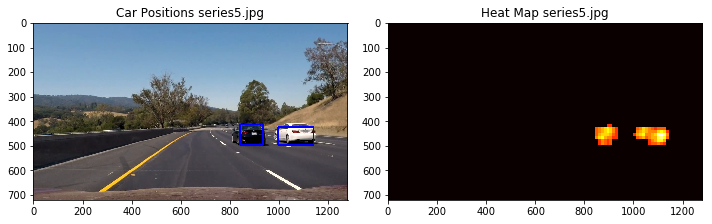

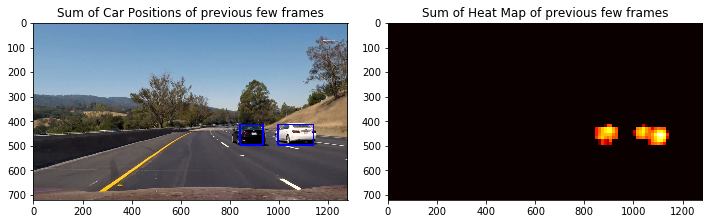

In [16]:
# using queue to average the boxes positions.
q = deque(maxlen=6)

for img in glob.glob('test_images/series*'):
    image = mpimg.imread(img)
    cp_image = np.copy(image)
    image = image.astype(np.float32)/255 # mpimg.imread *.jpg, 0 to 255

    hot_windows = []
    for window_size in ls_window_size:
        windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=window_size, xy_overlap=window_overlap)
    
        hot_windows.extend(search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))                      

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    box_list = hot_windows

    heat = add_heat(heat,box_list)
    heat = apply_threshold(heat,heat_threshold)

    heatmap = np.clip(heat, 0, 255)
    q.append(heatmap)
    labels = label(heatmap)
    heat_window_img = draw_labeled_bboxes(cp_image, labels, (0,0,255))

    fig = plt.figure(figsize = (10,10))
    plt.subplot(121)
    plt.imshow(heat_window_img)
    plt.title('Car Positions '+img.split('/')[1])
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map '+img.split('/')[1])
    fig.tight_layout()
    plt.savefig('output_images/'+img.split('/')[1],bbox_inches='tight')

labels = label(sum(q))
heat_window_img = draw_labeled_bboxes(cp_image, labels, (0,0,255))
plt.subplot(121)
plt.imshow(heat_window_img)
plt.title('Sum of Car Positions of previous few frames')
plt.subplot(122)
plt.imshow(sum(q), cmap='hot')
plt.title('Sum of Heat Map of previous few frames')
plt.savefig('output_images/sum_series.jpg',bbox_inches='tight')


In [17]:
# Generate photos to be tested from the project video
'''
import os, errno

try:
    os.makedirs('tmp')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

vc = cv2.VideoCapture('project_video.mp4')
c=1

if vc.isOpened():
    rval , frame = vc.read()
else:
    rval = False

while rval:
    rval, frame = vc.read()
    cv2.imwrite('./tmp/' + str(c) + '.jpg',frame)
    c = c + 1
    cv2.waitKey(1)
vc.release()
'''

"\nimport os, errno\n\ntry:\n    os.makedirs('tmp')\nexcept OSError as e:\n    if e.errno != errno.EEXIST:\n        raise\n\nvc = cv2.VideoCapture('project_video.mp4')\nc=1\n\nif vc.isOpened():\n    rval , frame = vc.read()\nelse:\n    rval = False\n\nwhile rval:\n    rval, frame = vc.read()\n    cv2.imwrite('./tmp/' + str(c) + '.jpg',frame)\n    c = c + 1\n    cv2.waitKey(1)\nvc.release()\n"

In [18]:
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
q_wobbly = deque(maxlen=12)
q_fp = deque(maxlen=4)

def process_image(image): # image is .jpg
    cp_image = np.copy(image)
    image = image.astype(np.float32)/255 # mpimg.imread *.jpg, 0 to 255

    hot_windows = []
    for window_size in ls_window_size:
        windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=window_size, xy_overlap=window_overlap)
    
        hot_windows.extend(search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))                      

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    box_list = hot_windows
    
    heat = add_heat(heat,box_list)
    #heat = apply_threshold(heat,heat_threshold)

    q_fp.append(heat)
    heat = apply_threshold(sum(q_fp)/float(len(q_fp)), 4)

    heatmap = np.clip(heat, 0, 255)
    q_wobbly.append(heatmap)
    labels = label(sum(q_wobbly))
    
    return draw_labeled_bboxes(cp_image, labels, (0,0,255))

In [20]:
out_video = 'out_test_video.mp4'
clip = VideoFileClip('test_video.mp4')
out_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(out_video, audio=False)


[MoviePy] >>>> Building video out_test_video.mp4
[MoviePy] Writing video out_test_video.mp4


 97%|█████████▋| 38/39 [05:26<00:08,  8.55s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_test_video.mp4 

CPU times: user 5min 15s, sys: 3.81 s, total: 5min 19s
Wall time: 5min 27s


In [21]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(out_video))

In [23]:
out_video = 'out_project_video.mp4'
#clip = VideoFileClip('project_video.mp4').subclip(25,35)
clip = VideoFileClip('project_video.mp4')
out_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(out_video, audio=False)


[MoviePy] >>>> Building video out_project_video.mp4
[MoviePy] Writing video out_project_video.mp4


100%|█████████▉| 1260/1261 [2:58:44<00:07,  7.38s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_project_video.mp4 

CPU times: user 2h 52min 56s, sys: 1min 47s, total: 2h 54min 43s
Wall time: 2h 58min 45s


In [ ]:
ystart = y_start_stop[0]
ystop = y_start_stop[1]
scale = 1.5

In [ ]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

def process_image_1(image):
    return find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

img = mpimg.imread('cutouts/bbox-example-image.jpg') 
out_img = process_image_1(img)

plt.imshow(out_img)

In [ ]:
out_video = 'find_project_video.mp4'
clip = VideoFileClip('project_video.mp4').subclip(15,35)
#clip = VideoFileClip('test_video.mp4').subclip(0,10)
out_clip = clip.fl_image(process_image_1) #NOTE: this function expects color images!!
%time out_clip.write_videofile(out_video, audio=False)
